# Introduction
## Using Google Search Volume and News Sentiment to Predict Natural Gas Prices with LSTMs
by Quinn Murphey, Adrian Ramos, and Gabriel Soliz

In [104]:
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import skopt as skopt
import skopt.plots
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data Fetch Stage

## US EIA NYMEX Dataset
TODO EXPLAIN DATASET

In [105]:
# Read csvs to dataframes
nymex_spot_df = pd.read_csv("data/US_EIA_NYMEX_spot.csv")
nymex_futures_df = pd.read_csv("data/US_EIA_NYMEX_futures.csv")

# Turn Date column into a datetime object rather than string
nymex_spot_df["Date"] = nymex_spot_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))
nymex_futures_df["Date"] = nymex_futures_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))

# Trim to Jan 2013 - Jun 2019
nymex_spot_df = nymex_spot_df[(nymex_spot_df["Date"] >= datetime(year=2004, month=1, day=1)) & (nymex_spot_df["Date"] <= datetime(year=2019, month=6, day=28))]
nymex_futures_df = nymex_futures_df[(nymex_futures_df["Date"] >= datetime(year=2004, month=1, day=1)) & (nymex_futures_df["Date"] <= datetime(year=2019, month=6, day=28))]

# Reset index
nymex_spot_df = nymex_spot_df.set_index("Date")
nymex_futures_df = nymex_futures_df.set_index("Date")

# Rename Columns
nymex_spot_df    = nymex_spot_df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Spot Price'})
nymex_futures_df = nymex_futures_df.rename(columns={'Natural Gas Futures Contract 1 (Dollars per Million Btu)':'Futures 1 Price','Natural Gas Futures Contract 2 (Dollars per Million Btu)':'Futures 2 Price','Natural Gas Futures Contract 3 (Dollars per Million Btu)':'Futures 3 Price','Natural Gas Futures Contract 4 (Dollars per Million Btu)':'Futures 4 Price'})

In [106]:
nymex_spot_df

,Spot Price
Date,
2004-01-05,6.28
2004-01-06,7.04
2004-01-07,6.61
2004-01-08,6.41
2004-01-09,6.91
...,...
2019-06-24,2.31
2019-06-25,2.31
2019-06-26,2.34


In [107]:
nymex_futures_df

,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,
2004-01-05,6.827,6.630,5.580,5.380
2004-01-06,7.082,6.630,5.580,5.380
2004-01-07,6.878,6.693,5.673,5.383
2004-01-08,7.094,6.958,5.808,5.493
2004-01-09,7.287,7.193,5.903,5.563
...,...,...,...,...
2019-06-24,2.303,2.284,2.256,2.291
2019-06-25,2.308,2.286,2.260,2.294
2019-06-26,2.291,2.268,2.244,2.275


## Google Trends Dataset

### PyTrends Scraper

In [170]:
import pytrends
from pytrends.request import TrendReq
import time
pytrend = TrendReq()

def get_daily_trends_as_df(keywords, categories, timeframe, countries, search_type):
    # Get pytrend suggestions and store them in exact_keywords
    keywords_codes = [pytrend.suggestions(keyword=i)[0] for i in keywords] 
    df_CODES= pd.DataFrame(keywords_codes)
    exact_keywords = df_CODES['mid'].to_list()

    # Store keywords alongside their respective categories
    individual_exact_keyword = list(zip(*[iter(exact_keywords)]*1, categories))
    individual_exact_keyword = [list(x) for x in individual_exact_keyword]

    # Split timeframe into 1 month chunks
    timeframe_start, timeframe_end = timeframe.split(" ")
    start_date = date.fromisoformat(timeframe_start)
    end_date = date.fromisoformat(timeframe_end)
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months=6)
    dates.append(end_date + relativedelta(days=1))

    # Compute number of fetches required
    max_fetches = len(countries) * len(keywords) * (len(dates) - 1)
    curr_fetches = 0

    word_id = 0
    trend_dict = {}
    for country in countries:
        for keyword, category in individual_exact_keyword:
            try:
                trend_dict[keyword] = pd.read_csv(f"data/google_trends_series/{keywords[word_id]}.csv")
                trend_dict[keyword] = trend_dict[keyword].set_index("Date")
                curr_fetches += (len(dates) - 1)
                print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete!", end='\r')

            except:
                trend_dict[keyword] = pd.DataFrame()
                # Fetch overall google trends for normalizing
                pytrend.build_payload(kw_list=[keyword], 
                                        timeframe = timeframe, 
                                        geo = country, 
                                        cat=category,
                                        gprop=search_type)
                overall_data = pytrend.interest_over_time()
                time.sleep(5)
                month_num = 0
                for i in range(len(dates)-1):
                    pytrend.build_payload(kw_list=[keyword], 
                                        timeframe = dates[i].isoformat() + " " + (dates[i + 1] - relativedelta(days=1)).isoformat(), 
                                        geo = country, 
                                        cat=category,
                                        gprop=search_type)
                    curr_fetches += 1
                    print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                    print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete! [\"{keywords[word_id]}\" {dates[i]}-{dates[i+1] - relativedelta(days=1)}]", end='\r')
                    time.sleep(5) # sleep to prevent google shutting us down
                    month_data = pytrend.interest_over_time()

                    # normalize data based on overall_data
                    for month in range(0,6):
                        if month != 5:
                            indicies = month_data.index.intersection(pd.date_range(dates[i] + relativedelta(months=month), (dates[i] + relativedelta(months=month+1)) - relativedelta(days=1), freq='d'))
                        else:
                            indicies = month_data.index.intersection(pd.date_range(dates[i] + relativedelta(months=month), dates[i+1] - relativedelta(days=1), freq='d'))
                        month_data.loc[indicies] = month_data.loc[indicies] * (overall_data.iloc[month_num][keyword].mean() / month_data.loc[indicies].mean())
                        month_num += 1

                    # add data to trend_dict then delete for mem purposes
                    trend_dict[keyword] = pd.concat([trend_dict[keyword], month_data], axis=0)
                    del month_data
                del overall_data

                # fix up data and save partial data
                trend_dict[keyword] = trend_dict[keyword].drop('isPartial', axis=1)
                trend_dict[keyword] = trend_dict[keyword].reset_index(level=0)
                trend_dict[keyword] = trend_dict[keyword].rename(columns={'date': 'Date', keyword:keywords[word_id]})
                trend_dict[keyword] = trend_dict[keyword].set_index("Date")
                trend_dict[keyword].to_csv(f"data/google_trends_series/{keywords[word_id]}.csv")
            word_id+=1

    df_trends = pd.concat(trend_dict, axis=1)
    df_trends.columns = df_trends.columns.droplevel(0) #drop outside header

    return df_trends

In [171]:
KEYWORDS            = ["Natural Gas","Oil","Coal","Nuclear Power","Wind Power","Hydroelectric","Solar Power","Gold","Silver","Platinum","Copper","Biofuel","Recession","CPI"]
KEYWORDS_CATEGORIES = [904,          904,  904,   0,               0,          0,               0,           904,   904,     904,       904,     0,        0,          0]
TIMEFRAME='2004-01-01 2019-06-28' # Jan 2013 - June 2019
COUNTRIES=["US"] # ISO country code
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

try:
    google_trends_df = pd.read_csv("data/google_trends_dataset.csv")
    google_trends_df = google_trends_df.set_index("Date")
    google_trends_df.index = pd.to_datetime(google_trends_df.index)
except:
    google_trends_df = get_daily_trends_as_df(KEYWORDS, KEYWORDS_CATEGORIES, TIMEFRAME, COUNTRIES, SEARCH_TYPE)
    google_trends_df.index = pd.to_datetime(google_trends_df.index)
    google_trends_df.to_csv("data/google_trends_dataset.csv")

google_trends_df

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2004-01-01,149.131931,0.000000,NaN,3.379360,28.007722,0.000000,30.413514,27.125000,6.766147,0.000000,0.000000,0.000000,0.000000,23.105590
2004-01-02,62.474187,30.827298,NaN,11.151890,23.339768,0.000000,53.454054,23.906780,5.799555,0.000000,0.000000,0.000000,0.000000,67.391304
2004-01-03,0.000000,0.000000,NaN,11.489826,29.874903,42.747913,47.924324,26.205508,21.587231,0.000000,55.426934,0.000000,0.000000,75.093168
2004-01-04,0.000000,0.000000,NaN,14.193314,59.749807,125.190317,59.905405,30.343220,17.720861,0.000000,0.000000,0.000000,6.752475,61.614907
2004-01-05,0.000000,0.000000,NaN,18.586483,16.804633,97.709516,18.432432,5.516949,8.377134,0.000000,0.000000,0.000000,15.346535,28.881988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,15.734729,20.883978,0.0,9.605839,19.633466,12.923077,64.275796,50.068886,29.814815,40.695103,31.723598,24.830189,17.133144,23.886545
2019-06-25,18.471204,17.403315,0.0,8.992701,20.451527,10.769231,62.412729,55.694604,32.971678,35.387046,10.842243,12.943396,19.512748,29.038545
2019-06-26,17.787086,14.618785,0.0,8.379562,16.361222,4.307692,62.412729,48.943743,25.956427,39.810427,31.723598,8.716981,16.181303,28.101818


## Financial Times Scraper

# Data Visualization

We will create a `plot` function that will be able to plot our data with, or without label and with or without predictions

In [190]:
def plot(data, units=None, feature_width=0, label_width=0, predictions=None, density=1, seperate=True, file=None, label_dates=[], labels=[]):
    """
    data: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted
    units: if seperate is True, a list of strings, else a string
    feature_width: input width of time series window
    label_width: label width of time series window
    predictions: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted (should match up with data column names)
    density: average every 'density' number of entries to end up plotting 1/density as many entries
    file: file to save figure to (None if no save)
    """
    # Verify units
    if units==None:
        units = [""] * len(data.columns)
    elif isinstance(units, str):
        units = [units] * len(data.columns)
    elif seperate and len(units) != len(data.columns):
        print("ERROR: Make sure units is the same length as data")
        return

    # Create new data if density != 1 using the mean of rolling windows
    if density != 1:
        # data
        data = data.rolling(density).mean().iloc[::density,:]

        # predictions
        if predictions is not None:
            predictions = predictions.rolling(density).mean().loc[data.index.intersection(predictions.index),:]

    # Create a 12x12 figure
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')

    # If plotting seperate Divide the fig into N subplots where N is the number of columns in data
    if seperate:
        ncols=math.ceil(math.sqrt(len(data.columns)))
        nrows=math.ceil( len(data.columns) / ncols)
    else: 
        plt.ylabel(units[0])
        plt.xlabel("Date")
    i = 1

    # Iterate over all columns in data
    for column, unit in zip(data.columns, units):
        # Label seperate subfigs
        if seperate:
            ax = plt.subplot(nrows,ncols,i)
            ax.set_title(column)
            plt.ylabel(unit)
            plt.xlabel('Date')
            plt.locator_params(axis='x', nbins=10)
        i+=1

        # Plot data
        plt.plot(data.index,data[column], label=column)

        # Plot labels
        if column in labels:
            plt.plot(data.loc[label_dates.intersection(data.index)][column], label=column + " labels" )

        # Plot predictions
        if feature_width != 0 and label_width != 0 and column in predictions.columns:
            # plot as one long series if label width is 1
            if label_width == 1:
                plt.plot(predictions.index, predictions[column], label=column + " Predictions")

            # plot as a lot of series if label width is > 1
            else:
                pass
            
        if seperate:
            plt.legend()

    if not seperate:
        plt.legend()
    plt.tight_layout()
    if file:
        plt.savefig(file)
    else:
        plt.show()

# Data Preprocessing Stage

## NYMEX

### Join dataframes (by date)

In [111]:
nymex_df = pd.concat([nymex_spot_df, nymex_futures_df],axis=1)
nymex_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,6.28,6.827,6.630,5.580,5.380
2004-01-06,7.04,7.082,6.630,5.580,5.380
2004-01-07,6.61,6.878,6.693,5.673,5.383
2004-01-08,6.41,7.094,6.958,5.808,5.493
2004-01-09,6.91,7.287,7.193,5.903,5.563
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


However, there are some NaN values due to the dates covered differing

In [112]:
nymex_df.isna().sum()

Spot Price         29
Futures 1 Price    33
Futures 2 Price    34
Futures 3 Price    34
Futures 4 Price    34
dtype: int64

### Fill spot price voids 
Interpolate all voids linearly (by column)

In [113]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Interpolate Weekends and Holidays

In [114]:
nymex_df = nymex_df.reindex(pd.date_range(nymex_df.index[0],nymex_df.index[-1],freq='d'))
nymex_df.index.names = ["Date"]
nymex_df


,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,6.28,6.827,6.630,5.580,5.380
2004-01-06,7.04,7.082,6.630,5.580,5.380
2004-01-07,6.61,6.878,6.693,5.673,5.383
2004-01-08,6.41,7.094,6.958,5.808,5.493
2004-01-09,6.91,7.287,7.193,5.903,5.563
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


In [115]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Plot NYMEX Data (note the exponential nature to it)

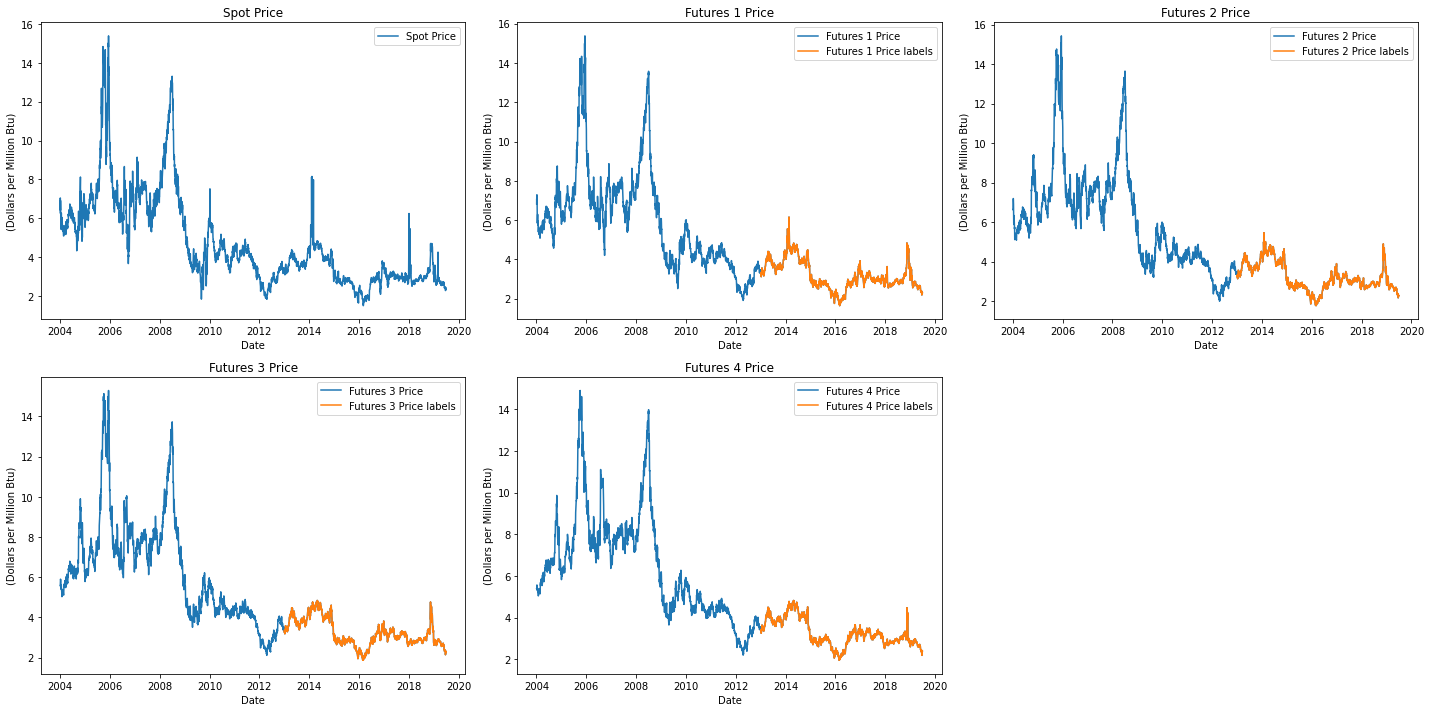

In [116]:
plot(
    nymex_df,
    units="(Dollars per Million Btu)", 
    seperate=True, 
    density=1, 
    file="images/nymex_data.png", 
    labels=nymex_df.columns[1:], 
    label_dates=pd.date_range(datetime(year=2013,month=1,day=1),datetime(year=2019,month=6,day=28),freq='d'))

### Normalize columns
First log all values: $x' = \log{x}$, then normalize: $x' = (x - \mu)/\sigma$

Check for negative values

In [117]:
means = {}
stds = {} 

def normalize_nymex(nymex_df):
    assert (nymex_df <= 0).sum().sum() == 0
    global means
    global stds

    nymex_df_normalized = np.log(nymex_df)
    for column in nymex_df_normalized.columns:
        means[column] = nymex_df_normalized[column].mean()
        stds[column] = nymex_df_normalized[column].std()
        nymex_df_normalized[column] = (nymex_df_normalized[column] - means[column]) / stds[column]
    
    return nymex_df_normalized

def restore_nymex(nymex_df_normalized):
    global means
    global stds

    for column in nymex_df_normalized:
        nymex_df_normalized[column] = nymex_df_normalized[column] * stds[column] + means[column]
    nymex_df = np.exp(nymex_df_normalized)
    return nymex_df

Log each value and Normalize each row

In [118]:
nymex_df_normalized = normalize_nymex(nymex_df)
nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2004-01-05,0.879004,1.032433,0.907849,0.472316,0.356587
2004-01-06,1.136008,1.114732,0.907849,0.472316,0.356587
2004-01-07,0.994220,1.049136,0.928988,0.509094,0.357830
2004-01-08,0.925099,1.118532,1.015779,0.561424,0.402903
2004-01-09,1.094076,1.178774,1.090022,0.597524,0.431119
...,...,...,...,...,...
2019-06-24,-1.370988,-1.406348,-1.474098,-1.542697,-1.545632
2019-06-25,-1.370988,-1.401481,-1.472142,-1.538755,-1.542716
2019-06-26,-1.341959,-1.418073,-1.489811,-1.554564,-1.561248


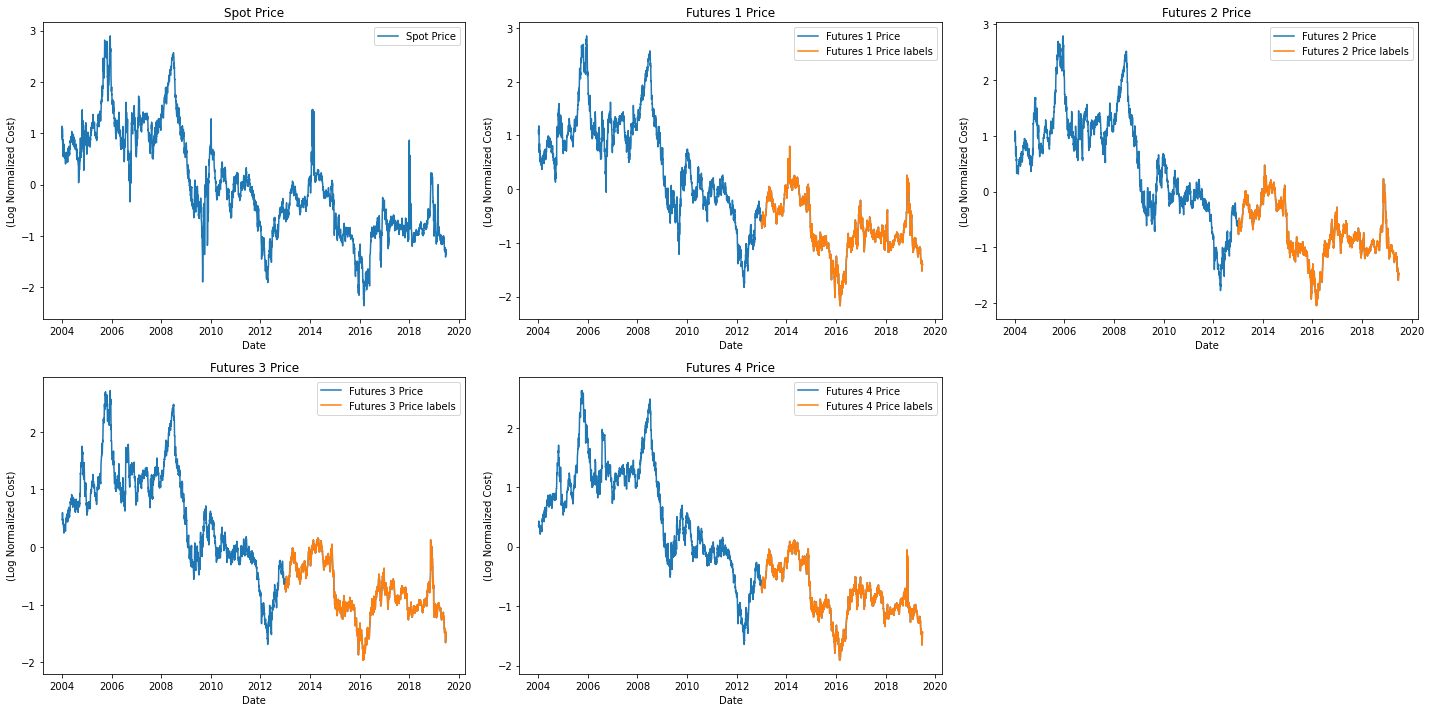

In [119]:
plot(
    nymex_df_normalized,
    units="(Log Normalized Cost)", 
    seperate=True, 
    density=1, 
    file="images/nymex_data_normalized.png", 
    labels=nymex_df.columns[1:], 
    label_dates=pd.date_range(datetime(year=2013,month=1,day=1),datetime(year=2019,month=6,day=28),freq='d'))

## Google Trends

### Plot Google Trends data

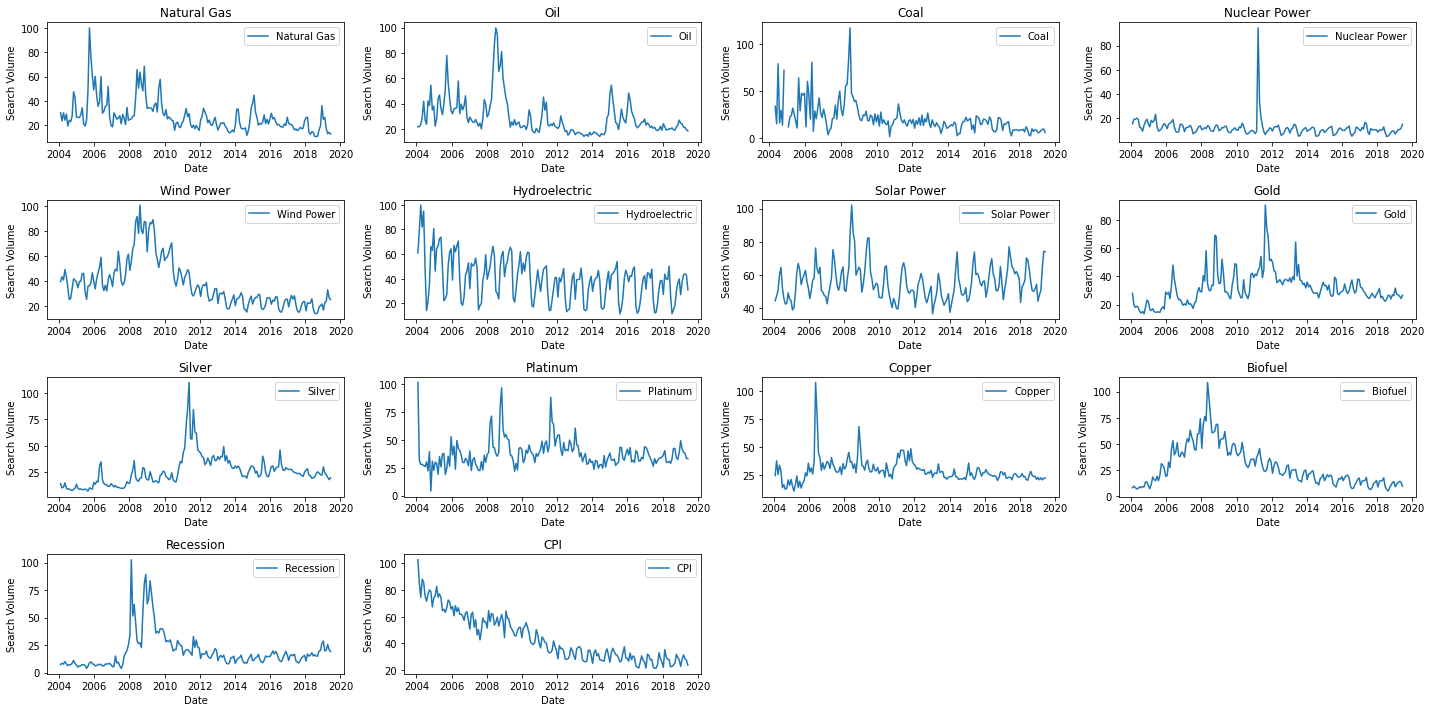

In [191]:
plot(google_trends_df,units="Search Volume", seperate=True, density=30, file="images/google_trends_data.png")

### Normalize Columns 
$x' = (x- \mu)/\sigma$

In [121]:
google_trends_df_normalized = google_trends_df.copy()

for column in google_trends_df_normalized.columns:
    google_trends_df_normalized[column] = (google_trends_df_normalized[column] - google_trends_df_normalized[column].mean()) / google_trends_df_normalized[column].std()

google_trends_df_normalized

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-01,-1.241024,-1.238112,-0.629954,-0.956079,-0.117670,-1.077455,-2.300032,0.274689,1.116316,0.887917,-1.050022,0.303348,-0.166768,-1.604700
2013-01-02,1.142040,0.073349,-0.629954,-0.738356,0.900198,-0.595713,-1.473651,1.393983,3.093022,0.713993,1.799259,1.103584,-0.323936,0.973983
2013-01-03,1.081710,-0.193389,-0.629954,-0.346455,0.364478,-0.948990,-1.212688,1.393983,2.455375,-0.677404,-0.084943,1.715530,-0.677564,0.270706
2013-01-04,1.443694,-0.282302,1.309685,-0.781901,0.578766,-0.692061,-1.517145,1.393983,2.136551,6.714392,0.926092,0.774075,-0.245352,0.270706
2013-01-05,-1.271189,-0.593496,-0.629954,-1.086713,-0.706962,-1.238035,-1.865094,1.347346,1.307610,1.148804,0.650355,-0.920542,-1.306237,-1.135849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-0.458097,0.003550,-0.629954,0.007022,-0.340797,-0.975437,0.756900,1.988734,0.316531,0.090636,0.553711,1.437186,0.441881,-0.417476
2019-06-25,0.099275,-0.431634,-0.629954,-0.170455,-0.282333,-1.093254,0.517776,2.574334,0.761473,-0.173935,-1.498205,-0.278389,0.827430,-0.063321
2019-06-26,-0.286598,-0.981340,-0.629954,-0.347933,-0.808506,-1.387795,0.597484,1.930174,-0.087961,0.090636,0.511835,-0.773266,0.276645,-0.181373


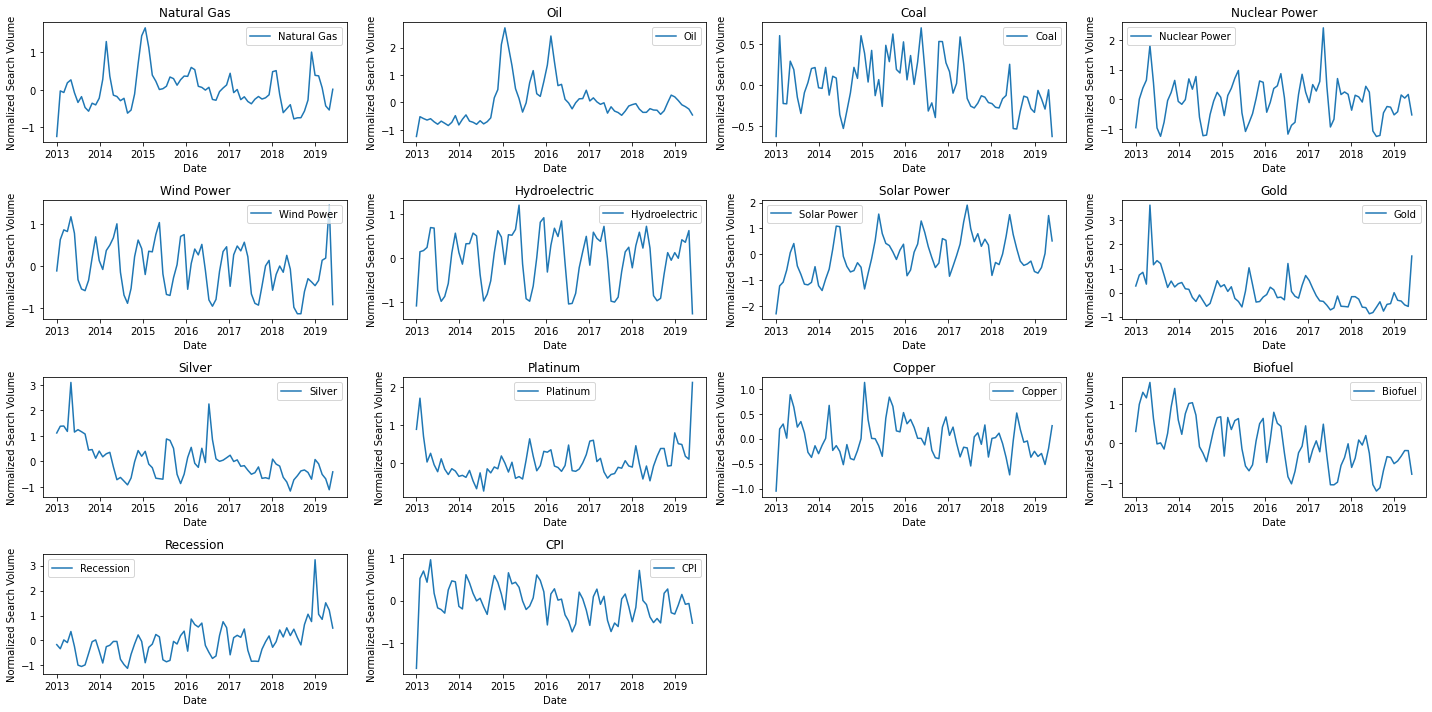

In [122]:
plot(google_trends_df_normalized,units="Normalized Search Volume", seperate=True, density=30, file="images/google_trends_data_normalized.png")

### Join individual dataframes into one dataframe

In [ ]:
full_df = pd.concat([nymex_df_normalized, google_trends_df_normalized],axis=1).loc[nymex_df_normalized.index]
full_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,,,,,,
2004-01-05,0.879004,1.032433,0.907849,0.472316,0.356587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-06,1.136008,1.114732,0.907849,0.472316,0.356587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-07,0.994220,1.049136,0.928988,0.509094,0.357830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-08,0.925099,1.118532,1.015779,0.561424,0.402903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-09,1.094076,1.178774,1.090022,0.597524,0.431119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-1.370988,-1.406348,-1.474098,-1.542697,-1.545632,-0.458097,0.003550,-0.629954,0.007022,-0.340797,-0.975437,0.756900,1.988734,0.316531,0.090636,0.553711,1.437186,0.441881,-0.417476
2019-06-25,-1.370988,-1.401481,-1.472142,-1.538755,-1.542716,0.099275,-0.431634,-0.629954,-0.170455,-0.282333,-1.093254,0.517776,2.574334,0.761473,-0.173935,-1.498205,-0.278389,0.827430,-0.063321
2019-06-26,-1.341959,-1.418073,-1.489811,-1.554564,-1.561248,-0.286598,-0.981340,-0.629954,-0.347933,-0.808506,-1.387795,0.597484,1.930174,-0.087961,0.090636,0.511835,-0.773266,0.276645,-0.181373


# Create Tensorflow Dataset

### Dataframe to Window Dataset function

In [129]:
def window_df_to_ds(df, features, labels, feature_width=7, label_width=1, label_dates=None):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    feature_width : time-width of features in window
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[feature_width:-(label_width)]

    def feature_gen():
        for label_start_date in label_dates:
            new_feature = df.loc[df.index.intersection(pd.date_range(label_start_date - relativedelta(days=feature_width), label_start_date - relativedelta(days=1), freq='d'))][features].values
            yield tf.convert_to_tensor(new_feature, dtype=np.float64)
    
    def label_gen():
        for label_start_date in label_dates:
            new_label = df.loc[df.index.intersection(pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'))][labels].values
            yield tf.convert_to_tensor(new_label, dtype=np.float64)

    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_generator(feature_gen,
                                                     output_signature=(tf.TensorSpec(shape=(feature_width, len(features)), dtype=np.float64, name='Feature'))
                                                    )
    label_dataset = tf.data.Dataset.from_generator(label_gen,
                                                     output_signature=(tf.TensorSpec(shape=(label_width, len(labels)), dtype=np.float64, name='Label'))
                                                    )

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Dataframe to variable length input Dataset

In [130]:
def variable_df_to_ds(df, features, labels, label_width=1, label_dates=None):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[1:-(label_width)]

    start_date = df.index[0]
    end_date = df.index[-1]

    # Create feature generator
    def feature_gen():
        for label_start_date in label_dates:
            new_feature = df.loc[df.index.intersection(pd.date_range(start_date, label_start_date - relativedelta(days=1), freq='d'))][features].values
            yield tf.convert_to_tensor(new_feature, dtype=np.float64)

    def label_gen():
        for label_start_date in label_dates:
            new_label = df.loc[df.index.intersection(pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'))][labels].values
            yield tf.convert_to_tensor(new_label, dtype=np.float64)

    
    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_generator(feature_gen,
                                                     output_signature=(tf.TensorSpec(shape=(None, len(features)), dtype=np.float64, name='Feature'))
                                                    )
    label_dataset = tf.data.Dataset.from_generator(label_gen,
                                                     output_signature=(tf.TensorSpec(shape=(label_width, len(labels)), dtype=np.float64, name='Label'))
                                                    )

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Train Validate Test Dataset Split Function

In [131]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, batch_size=8, repeats=1, ds_size=None):
    """
    ds: tensorflow zip dataset
    train_split : 
    val_split :
    test_split :
    shuffle : whether to shuffle the ds or not
    """
    assert (train_split + val_split + test_split) == 1
    shuffle_size=10000
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=0)
    
    if ds_size is None:
        ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).repeat(repeats).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).repeat(repeats).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).repeat(repeats).batch(batch_size)
    
    return train_ds, val_ds, test_ds

### Finalize Dataset

In [132]:
FEATURES = full_df.columns
LABELS = ['Futures 1 Price','Futures 2 Price','Futures 3 Price','Futures 4 Price']
FEATURE_WIDTH = 7
LABEL_WIDTH   = 1
TIMEFRAME = pd.date_range(datetime(year=2013, month=1, day=1), datetime(year=2019, month=6, day=28))
LABEL_DATES = pd.date_range(datetime(year=2013, month=1, day=2), datetime(year=2019, month=6, day=28))

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1
BATCH_SIZE  = 1
REPEATS     = 1

#dataset = window_df_to_ds(full_df, features=FEATURES, labels=LABELS, feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, label_dates=LABEL_DATES)
dataset = variable_df_to_ds(full_df.loc[TIMEFRAME], features=FEATURES, labels=LABELS, label_width=LABEL_WIDTH, label_dates=LABEL_DATES)
train_ds, val_ds, test_ds = train_val_test_split(dataset, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT, batch_size=BATCH_SIZE, repeats=REPEATS, ds_size=len(LABEL_DATES))

In [133]:
for x,y in dataset.take(10):
    print(x.shape, y.shape)

(1, 19) (1, 4)
(2, 19) (1, 4)
(3, 19) (1, 4)
(4, 19) (1, 4)
(5, 19) (1, 4)
(6, 19) (1, 4)
(7, 19) (1, 4)
(8, 19) (1, 4)
(9, 19) (1, 4)
(10, 19) (1, 4)


In [44]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 4), dtype=tf.float64, name=None))>

# Model Training Stage

### Predictions Function
Returns predictions df from a given dataset and model

In [27]:
def get_predictions_df(model, dataset, label_width, labels, index):
    predictions = np.ndarray((len(dataset), label_width, len(labels)))
    dataset = dataset.batch(1)

    for i, tensor in enumerate(iter(dataset)):
        predictions[i,:,:] = model(tensor[0]).numpy()

    # get rid of time dim
    if label_width == 1:
        predictions = predictions.reshape((len(dataset), len(labels)))
    else: # compress time dim
        pass

    predictions_df = pd.DataFrame(predictions, index=index, columns=labels)
    predictions_df = restore_nymex(predictions_df)
    return predictions_df

### Create Model Function
Creates a custom LSTM model from a set of parameters

In [28]:
def create_lstm_model():
    pass

### Fitness Function (for evaluating hyperparameters)

In [29]:
MAX_EPOCHS = 40

dim_learning_rate = skopt.space.Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')
dim_feature_width = skopt.space.Integer(low=1, high=365, name='feature_width')
dim_num_lstm_layers = skopt.space.Integer(low=1, high=5, name='num_lstm_layers')
dim_num_lstm_nodes = skopt.space.Integer(low=5, high=2048, name='num_lstm_nodes')
dim_dropout_rate = skopt.space.Real(low=0, high=1, prior='uniform', name='dropout_rate')

dimensions = [
    dim_learning_rate,
    dim_feature_width,
    dim_num_lstm_layers,
    dim_num_lstm_nodes,
    dim_dropout_rate 
]

@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(learning_rate, feature_width, num_lstm_layers, num_lstm_nodes,dropout_rate):
    pass

### Perform Baesian Hyperparameter Search

In [30]:
best_loss = np.inf



TODO: REWRITE CODE TO HANDLE ARBITRARY LENGTH TIME-SERIES

In [134]:
stackedLstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, return_sequences=False, input_shape=(None,len(FEATURES))),
    tf.keras.layers.Dense(units=LABEL_WIDTH*len(LABELS)),
    tf.keras.layers.Reshape([LABEL_WIDTH, -1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=3,
                                                mode='min')

stackedLstm.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(learning_rate=0.5e-3),
            metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])

history = stackedLstm.fit(train_ds, epochs=100, steps_per_epoch=len(LABEL_DATES)/BATCH_SIZE,
                  validation_data=val_ds,
                 callbacks=[early_stopping]) 

Epoch 1/100
 480/2369 [=====>........................] - ETA: 4:54 - loss: 0.0299 - mean_absolute_error: 0.1247 - root_mean_squared_error: 0.1729

KeyboardInterrupt: 

In [51]:
stackedLstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1024)              4276224   
                                                                 
 dense_3 (Dense)             (None, 4)                 4100      
                                                                 
 reshape_3 (Reshape)         (None, 1, 4)              0         
                                                                 
Total params: 4,280,324
Trainable params: 4,280,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predictions_df = get_predictions_df(model=stackedLstm, dataset=dataset, label_width=LABEL_WIDTH, labels=LABELS, index=LABEL_DATES)
plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=1, seperate=True, file=None)

KeyboardInterrupt: 

# Model Testing Stage